In [59]:
import time

import numpy as np
from IPython import display
import pylab as pl
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
edges = np.loadtxt('item/MNIST/edges.txt', dtype=np.int64)

In [3]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

train_data = X[:60000]
train_targets = y[:60000]
train_targets = np.array(list(map(int, train_targets)))

In [37]:
class RandomWalker():
    def __init__(self, edges, y, seed=42, init_idx=0):
        self.edges = edges
        self.node_targets = y
        self.rng = np.random.default_rng(seed)
        self.index = init_idx
    
    def walk(self):
        choices = np.unique(self.edges[np.isin(edges, self.index).any(1)])
        choices = choices[choices != self.index]
        self.index = self.rng.choice(choices)

In [4]:
def hopping_from_one_class(edges, node_targets, label, max_hop=100, out=False):
    nodes_init = np.nonzero(node_targets == label)[0]
    hop_count = np.ones(len(node_targets)) * max_hop

    nodes_hopped = nodes_init
    hop_count[nodes_hopped] = 0
    if out:
        print(f'0-hopped nodes num:{len(nodes_hopped)}')
    k = 1
    while len(nodes_hopped) < len(node_targets):
        edges_hopped = edges[np.isin(edges, nodes_hopped).any(1)]
        nodes_hopped = np.unique(edges_hopped)
        hop_count[nodes_hopped] = np.minimum(hop_count[nodes_hopped], k)
        if out:
            print(f'{k}-hopped nodes num:{len(nodes_hopped)}')
        k += 1

    return hop_count

In [5]:
to_another_class = [hopping_from_one_class(edges, train_targets, c) for c in np.unique(train_targets)]
to_another_class = np.array(to_another_class, dtype=np.int32).T

In [56]:
class TimeWalker():
    def __init__(self, edges, train_targets, to_another_class, seed=42, index=0):
        self.edges = edges
        self.node_targets = train_targets
        self.to_another_class = to_another_class
        self.rng = np.random.default_rng(seed)
        self.index = index
        self.destination = [1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
        self.T = 1
        self._setDestination()
        self._setNodeInfo()
    
    def _setNodeInfo(self):
        self.num_hops = self.to_another_class[self.index, self.dest]
        self.label = self.node_targets[self.index]
        
    def _setDestination(self):
        self.dest = self.destination[self.node_targets[self.index]]
    
    def _softmax(self, logit):
        nume = np.exp(logit - np.max(logit)) / self.T
        p = nume / np.sum(nume)
        return p
    
    def _choice(self):
        choices = np.unique(self.edges[np.isin(self.edges, self.index).any(1)])
        cond = np.isin(self.node_targets[choices], [self.label, self.dest])
        choices = choices[cond]
        logit = -1 * self.to_another_class[choices, self.dest]
        p = self._softmax(logit)
        return self.rng.choice(choices, p=p)
    
    def walk(self):
        self.index = self._choice()
        self._setNodeInfo()
        if self.num_hops == 0:
            self._setDestination()
        #print(f'{self.num_hops} hops to {self.dest} from {self.label}')

In [57]:
tw = TimeWalker(
    edges,
    train_targets,
    to_another_class
)

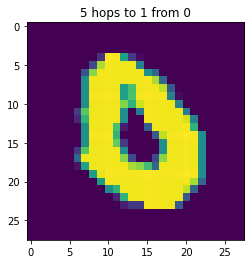

In [58]:
for i in range(100):
    tw.walk()
    plot(train_data, tw)
    time.sleep(0.1)

In [10]:
def plot(train_data, tw):
    plt.gcf().clear()
    plt.imshow(train_data[tw.index].reshape(28,28))
    #plt.show()
    plt.title(f'{tw.num_hops} hops to {tw.dest} from {tw.label}')
    display.clear_output(wait=True)
    display.display(pl.gcf())
    plt.close()